In [1]:
# !pip install scikit-learn
# !pip install tensorflow
# !pip install matplotlib
# !pip install pandas
# !pip install opencv-python
# !pip install seaborn

In [2]:
import h5py
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline

In [3]:
import os
import cv2
import h5py
import numpy as np

def load_data(dataset_path, splits=['train', 'val', 'test']):
    X, y = {}, {}

    IMG_SIZE = 224

    # Label_Mapping = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral', 7:'Contempt'}
    Label_Mapping = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7'}

    
    for split in splits:
        # PATH = os.path.join(path_prefix, dataset_name, split)
        PATH = os.path.join(dataset_path, split)
        X[split], y[split] = [], []
        for classes in Label_Mapping.values():
            class_path = os.path.join(PATH, classes)
            class_numeric = next((k for k, v in Label_Mapping.items() if v == classes), None)

            try:
                for sample in os.listdir(class_path):
                    sample_path = os.path.join(class_path, sample)
                    image = cv2.imread(sample_path, cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                    X[split].append(image)
                    y[split].append(class_numeric)
            except:
                print(f"Dataset doesn't have class {classes}, therefore skipping.")
    
    # Convert to numpy arrays
    for split in splits:
        X[split] = np.array(X[split])
        y[split] = np.array(y[split])
        
    return X, y

In [4]:
NUM_CLASSES = 7
IMG_SHAPE = (120, 120, 3) # (224, 224, 3)
BATCH_SIZE = 8

TRAIN_EPOCH = 300
TRAIN_LR = 1e-3
TRAIN_ES_PATIENCE = 15
TRAIN_LR_PATIENCE = 9
TRAIN_MIN_LR = 1e-6
TRAIN_DROPOUT = 0.1

FT_EPOCH = 500
FT_LR = 1e-5
FT_LR_DECAY_STEP = 80.0
FT_LR_DECAY_RATE = 1
FT_ES_PATIENCE = 20
FT_DROPOUT = 0.2

ES_LR_MIN_DELTA = 0.003

In [5]:
def Model(component = 'Training', input_layer=None, sample_resizing=None, data_augmentation=None, 
          preprocess_input=None, base_model=None, self_attention=None, patch_extraction=None, 
          global_average_layer=None, pre_classification=None, prediction_layer=None):
    
    if component == 'Training':
        input_layer = tf.keras.Input(shape=IMG_SHAPE, name='universal_input')
        sample_resizing = tf.keras.layers.Resizing(224, 224, name="resize")
        data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(mode='horizontal'), tf.keras.layers.RandomContrast(factor=0.3)], name="augmentation")
        preprocess_input = tf.keras.applications.mobilenet.preprocess_input
        backbone = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
        backbone.trainable = False
        base_model = tf.keras.Model(backbone.input, backbone.layers[-29].output, name='base_model')

        self_attention = tf.keras.layers.Attention(use_scale=True, name='attention')
        patch_extraction = tf.keras.Sequential([
            tf.keras.layers.SeparableConv2D(256, kernel_size=4, strides=4, padding='same', activation='relu'), 
            tf.keras.layers.SeparableConv2D(256, kernel_size=2, strides=2, padding='valid', activation='relu'), 
            tf.keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', activation='relu')
        ], name='patch_extraction')
        global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='gap')
        pre_classification = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu'), 
                                                tf.keras.layers.BatchNormalization()], name='pre_classification')
        prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name='classification_head')

        inputs = input_layer
        x = sample_resizing(inputs)
        x = data_augmentation(x)
        x = preprocess_input(x)
        x = base_model(x, training=False)
        x = patch_extraction(x)
        x = global_average_layer(x)
        x = tf.keras.layers.Dropout(TRAIN_DROPOUT)(x)
        x = pre_classification(x)
        x = tf.keras.layers.Reshape((1, 32))(x) 
        x = self_attention([x, x])
        x = tf.keras.layers.Reshape((32,))(x) 
        outputs = prediction_layer(x)
        model = tf.keras.Model(inputs, outputs, name='train-head')
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=TRAIN_LR, global_clipnorm=3.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model, input_layer, sample_resizing, data_augmentation, preprocess_input, base_model, self_attention, patch_extraction, global_average_layer, pre_classification, prediction_layer
    elif component == 'Finetuning':
        preprocess_input = tf.keras.applications.mobilenet.preprocess_input

        unfreeze = 59
        base_model.trainable = True
        fine_tune_from = len(base_model.layers) - unfreeze
        for layer in base_model.layers[:fine_tune_from]:
            layer.trainable = False
        for layer in base_model.layers[fine_tune_from:]:
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = False

        inputs = input_layer
        x = sample_resizing(inputs)
        x = data_augmentation(x)
        x = preprocess_input(x)
        x = base_model(x, training=False)
        x = patch_extraction(x)
        x = tf.keras.layers.SpatialDropout2D(FT_DROPOUT)(x)
        x = global_average_layer(x)
        x = tf.keras.layers.Dropout(FT_DROPOUT)(x)
        x = pre_classification(x)
        x = tf.keras.layers.Reshape((1, 32))(x) 
        x = self_attention([x, x])
        x = tf.keras.layers.Reshape((32,))(x) 
        x = tf.keras.layers.Dropout(FT_DROPOUT)(x)
        outputs = prediction_layer(x)
        model = tf.keras.Model(inputs, outputs, name='finetune-backbone')
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=FT_LR, global_clipnorm=3.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

def TrainPAttLite(data_directory, dataset_name, model_cp):
    X, y = load_data(data_directory, splits=['train', 'validation', 'test'])

    X_train, y_train = shuffle(X['train'], y['train'])
    X_valid, y_valid = X['validation'], y['validation']
    X_test, y_test = X['test'], y['test']

    # Convert images to grayscale and resize them
    X_train = np.array([cv2.cvtColor(cv2.resize(img, (120, 120)), cv2.COLOR_RGB2GRAY) for img in X_train])
    X_valid = np.array([cv2.cvtColor(cv2.resize(img, (120, 120)), cv2.COLOR_RGB2GRAY) for img in X_valid])
    X_test = np.array([cv2.cvtColor(cv2.resize(img, (120, 120)), cv2.COLOR_RGB2GRAY) for img in X_test])
    
    # Convert grayscale to pseudo-RGB by repeating the grayscale values across 3 channels
    X_train = np.repeat(np.expand_dims(X_train, axis=-1), 3, axis=-1)
    X_valid = np.repeat(np.expand_dims(X_valid, axis=-1), 3, axis=-1)
    X_test = np.repeat(np.expand_dims(X_test, axis=-1), 3, axis=-1)

    print("Shape of train_sample: {}".format(X_train.shape))
    print("Shape of train_label: {}".format(y_train.shape))
    print("Shape of valid_sample: {}".format(X_valid.shape))
    print("Shape of valid_label: {}".format(y_valid.shape))
    print("Shape of test_sample: {}".format(X_test.shape))
    print("Shape of test_label: {}".format(y_test.shape))

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    model, input_layer, sample_resizing, data_augmentation, preprocess_input, base_model, self_attention, patch_extraction, global_average_layer, pre_classification, prediction_layer = Model('Training')

    # Training Procedure
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=TRAIN_ES_PATIENCE, min_delta=ES_LR_MIN_DELTA, restore_best_weights=True)
    learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=TRAIN_LR_PATIENCE, verbose=0, min_delta=ES_LR_MIN_DELTA, min_lr=TRAIN_MIN_LR)
    checkpoint_callback = ModelCheckpoint( #Modification
        f'{dataset_name}_model_checkpoint.keras',  # The path to save the model
        monitor='val_accuracy',  # Monitor validation accuracy
        save_best_only=True,  # Save the best model (with the highest validation accuracy)
        mode='max',  # 'max' for accuracy, 'min' for loss
        verbose=1  # Display messages when saving the model
    )

    if model_cp is not None:
        model = tf.keras.models.load_model(model_cp) if model_cp is not None else model
        input_layer = model.input
        sample_resizing = model.get_layer('resize')
        data_augmentation = model.get_layer('augmentation')
        base_model = model.get_layer('base_model')
        self_attention = model.get_layer('attention')
        patch_extraction = model.get_layer('patch_extraction')
        global_average_layer = model.get_layer('gap')
        pre_classification = model.get_layer('pre_classification')
        prediction_layer = model.get_layer('classification_head')

    print("Training")
    history = model.fit(X_train, y_train, epochs=TRAIN_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), verbose=1, 
                        class_weight=class_weights, callbacks=[early_stopping_callback, learning_rate_callback, checkpoint_callback])

    model = Model('Finetuning', input_layer, sample_resizing, data_augmentation, preprocess_input, base_model, self_attention, patch_extraction, global_average_layer, pre_classification, prediction_layer)
    
    # Custom function to ensure the scheduler output is a float
    def lr_schedule(epoch, lr):
        return float(scheduler(epoch))

    # Training Procedure
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=ES_LR_MIN_DELTA, patience=FT_ES_PATIENCE, restore_best_weights=True)
    scheduler = keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=FT_LR, decay_steps=FT_LR_DECAY_STEP, decay_rate=FT_LR_DECAY_RATE)
    # scheduler_callback = tf.keras.callbacks.LearningRateScheduler(schedule=scheduler)
    scheduler_callback = tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)

    checkpoint_callback = ModelCheckpoint( #Modification
        f'{dataset_name}_model_finetune_checkpoint.keras',  # The path to save the model
        monitor='val_accuracy',  # Monitor validation accuracy
        save_best_only=True,  # Save the best model (with the highest validation accuracy)
        mode='max',  # 'max' for accuracy, 'min' for loss
        verbose=1  # Display messages when saving the model
    )

    print("Finetuning")
    history_finetune = model.fit(X_train, y_train, epochs=FT_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), verbose=1, 
                                initial_epoch=history.epoch[-TRAIN_ES_PATIENCE], callbacks=[early_stopping_callback, scheduler_callback, tensorboard_callback, checkpoint_callback])

    model.save(f'{dataset_name}_NEW.keras')
    model.save(f'ModelsReadyForComparison/{dataset_name}.keras')
    


In [8]:
# NUM_CLASSES = 7
# TrainPAttLite('../../Datasets/FER_Structured_Aligned', "FER_Structured_Aligned", model_cp = None) #11hrs | 60% ACC on Test Set | 132 Epochs
# NUM_CLASSES = 8
# TrainPAttLite('../../Datasets/AffectNet_Structured_Aligned', "AffectNet_Structured_Aligned", model_cp = None) #14hrs | 55% ACC on Test Set | 111 Epochs
NUM_CLASSES = 7
TrainPAttLite('../../Datasets/RAF-DB_Structured_Aligned', "RAF-DB_Structured_Aligned", model_cp = None) #2hrs | 80% ACC on Test Set | 63 Epochs

Dataset doesn't have class 7, therefore skipping.
Dataset doesn't have class 7, therefore skipping.
Dataset doesn't have class 7, therefore skipping.
Shape of train_sample: (12271, 120, 120, 3)
Shape of train_label: (12271,)
Shape of valid_sample: (1534, 120, 120, 3)
Shape of valid_label: (1534,)
Shape of test_sample: (1534, 120, 120, 3)
Shape of test_label: (1534,)
Training
Epoch 1/300


c:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\PAtt-Lite\.venv\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1534/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4254 - loss: 1.6658
Epoch 1: val_accuracy improved from -inf to 0.62647, saving model to RAF-DB_Structured_Aligned_model_checkpoint.keras
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 91s 58ms/step - accuracy: 0.4255 - loss: 1.6657 - val_accuracy: 0.6265 - val_loss: 1.0417 - learning_rate: 0.0010
Epoch 2/300
1533/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6441 - loss: 1.1941
Epoch 2: val_accuracy improved from 0.62647 to 0.74316, saving model to RAF-DB_Structured_Aligned_model_checkpoint.keras
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 88s 57ms/step - accuracy: 0.6441 - loss: 1.1941 - val_accuracy: 0.7432 - val_loss: 0.7259 - learning_rate: 0.0010
Epoch 3/300
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6946 - loss: 1.0654
Epoch 3: val_accuracy did not improve from 0.74316
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 88s 57ms/step - accuracy: 0.6946 - loss: 1.0654 - val_accuracy: 0.5522 - val_loss: 1.2654 - learning_rate: 0.0010
Epoch 4/300
1534/

In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import seaborn as sns

def TestPAttLite(data_directory, model_path, dataset=['test'], ignored_labels=[]):
    images = []
    labels = []

    for directory in dataset:
        X, y = load_data(data_directory, splits=[directory])
        X_dir, y_dir = X[directory], y[directory]

        # Convert images to grayscale and resize them
        X_dir = np.array([cv2.cvtColor(cv2.resize(img, (120, 120)), cv2.COLOR_RGB2GRAY) for img in X_dir])
        X_dir = np.repeat(np.expand_dims(X_dir, axis=-1), 3, axis=-1)

        # Filter out ignored labels
        X_filtered = []
        y_filtered = []
        for img, label in zip(X_dir, y_dir):
            if label not in ignored_labels:
                X_filtered.append(img)
                y_filtered.append(label)

        images.append(np.array(X_filtered))
        labels.append(np.array(y_filtered))

    # Combine all valid images and labels
    all_images = np.concatenate(images, axis=0)
    all_labels = np.concatenate(labels, axis=0)

    # Load the model
    model = load_model(model_path)

    # Get prediction probabilities
    y_pred = model.predict(all_images)
    all_preds = np.argmax(y_pred, axis=1)

    print("Labels: ", len(all_labels))
    print("Predictions: ", len(all_preds))

    # Get valid test labels only
    test_labels = np.unique(all_labels)

    # Replace invalid predictions
    modified_preds = []
    for i, pred in enumerate(all_preds):
        if pred not in test_labels:
            sorted_pred_indices = np.argsort(y_pred[i])[::-1]  # Descending order
            for idx in sorted_pred_indices:
                if idx in test_labels:
                    modified_preds.append(idx)
                    break
        else:
            modified_preds.append(pred)

    modified_preds = np.array(modified_preds)

    # Compute metrics
    accuracy = accuracy_score(all_labels, modified_preds)
    precision_weighted = precision_score(all_labels, modified_preds, average='weighted', zero_division=0)
    precision_macro = precision_score(all_labels, modified_preds, average='macro', zero_division=0)
    precision_micro = precision_score(all_labels, modified_preds, average='micro', zero_division=0)
    recall_weighted = recall_score(all_labels, modified_preds, average='weighted', zero_division=0)
    recall_macro = recall_score(all_labels, modified_preds, average='macro', zero_division=0)
    recall_micro = recall_score(all_labels, modified_preds, average='micro', zero_division=0)
    f1_weighted = f1_score(all_labels, modified_preds, average='weighted', zero_division=0)
    f1_macro = f1_score(all_labels, modified_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, modified_preds, average='micro', zero_division=0)

    report = classification_report(all_labels, modified_preds, zero_division=0)
    cm = confusion_matrix(all_labels, modified_preds, labels=[l for l in range(8) if l not in ignored_labels])

    # Print metrics
    print("Test Accuracy:", accuracy)
    print("Precision (Weighted):", precision_weighted)
    print("Precision (Macro):", precision_macro)
    print("Precision (Micro):", precision_micro)
    print("Recall (Weighted):", recall_weighted)
    print("Recall (Macro):", recall_macro)
    print("Recall (Micro):", recall_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("\nClassification Report:\n", report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


c:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\PAtt-Lite\.venv\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step

c:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\PAtt-Lite\.venv\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step
Labels:  902
Predictions:  902
Test Accuracy: 0.7904656319290465
Precision (Weighted): 0.8284895380399052
Precision (Macro): 0.6002900002414918
Precision (Micro): 0.7904656319290465
Recall (Weighted): 0.7904656319290465
Recall (Macro): 0.5404735379909095
Recall (Micro): 0.7904656319290465
F1 Score (Weighted): 0.7943570573330935
F1 Score (Macro): 0.5342541420388033
F1 Score (Micro): 0.7904656319290465

Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.24      0.20        45
           1       0.86      0.20      0.33        59
           2       0.25      0.20      0.22        25
           3       0.90      1.00      0.95        69
           4       0.16      0.36      0.22        28
           5       0.96      0.88      0.92        83
           6       0.90      0.90      0.90       593

    accuracy                           0.79       902
   macro avg       0.60      0.54      0.5

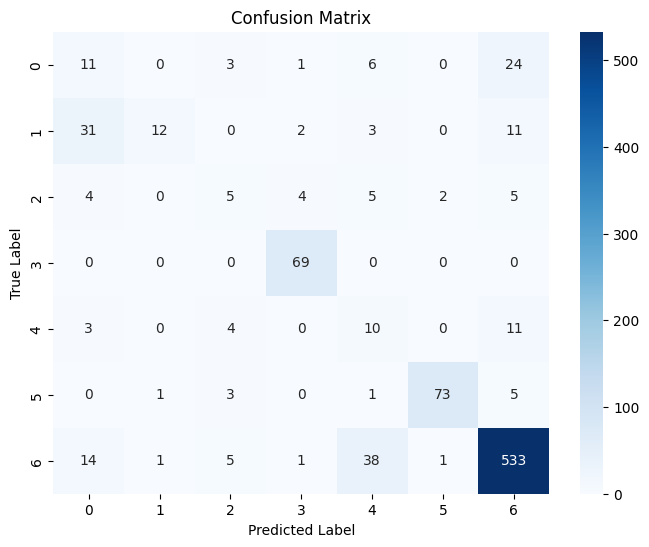

In [ ]:
# data_directory = '../../Datasets/FER_Structured_Aligned'
# data_directory = '../../Datasets/AffectNet_Structured_Aligned'
# data_directory = '../../Datasets/RAF-DB_Structured_Aligned'
# data_directory = '../../Datasets/JAFFE_Structured_Aligned'
data_directory = '../../Datasets/CK+_Structured_Aligned'
model_path = 'ModelsReadyForComparison/FER_Structured_Aligned.keras'

TestPAttLite(data_directory, model_path, dataset=['test'], ignored_labels=[7])

c:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\PAtt-Lite\.venv\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step

c:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\PAtt-Lite\.venv\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step
Labels:  920
Predictions:  920
Test Accuracy: 0.6717391304347826
Precision (Weighted): 0.8011738067679007
Precision (Macro): 0.5190631551367402
Precision (Micro): 0.6717391304347826
Recall (Weighted): 0.6717391304347826
Recall (Macro): 0.5865291346528224
Recall (Micro): 0.6717391304347826
F1 Score (Weighted): 0.7145559806323935
F1 Score (Macro): 0.519820921603181
F1 Score (Micro): 0.6717391304347826

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.58      0.55        45
           1       0.50      0.86      0.63        59
           2       0.10      0.60      0.17        25
           3       0.95      1.00      0.97        69
           4       0.38      0.29      0.33        28
           5       0.54      0.52      0.53        83
           6       0.94      0.68      0.79       593
           7       0.23      0.17      0.19        18

    accuracy                           0.67

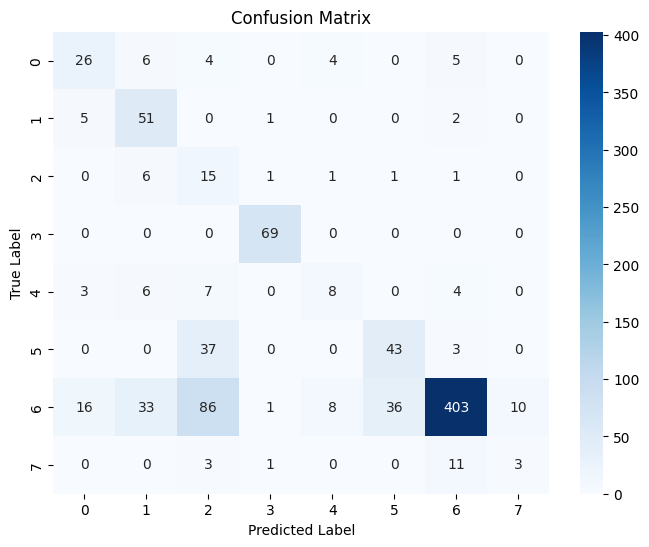

In [ ]:
# data_directory = '../../Datasets/AffectNet_Structured_Aligned'
# data_directory = '../../Datasets/FER_Structured_Aligned'
# data_directory = '../../Datasets/RAF-DB_Structured_Aligned'
# data_directory = '../../Datasets/JAFFE_Structured_Aligned'
data_directory = '../../Datasets/CK+_Structured_Aligned'
model_path = 'ModelsReadyForComparison/AffectNet_Structured_Aligned.keras'

TestPAttLite(data_directory, model_path, dataset=['test'])

c:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\PAtt-Lite\.venv\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step

c:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\PAtt-Lite\.venv\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step
Labels:  902
Predictions:  902
Test Accuracy: 0.6762749445676275
Precision (Weighted): 0.7400003440796102
Precision (Macro): 0.42900316466705923
Precision (Micro): 0.6762749445676275
Recall (Weighted): 0.6762749445676275
Recall (Macro): 0.529293409686093
Recall (Micro): 0.6762749445676275
F1 Score (Weighted): 0.6880118966141417
F1 Score (Macro): 0.4567961610534548
F1 Score (Micro): 0.6762749445676275

Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.11      0.12        45
           1       0.51      0.53      0.52        59
           2       0.19      0.16      0.17        25
           3       0.49      0.97      0.65        69
           4       0.30      0.39      0.34        28
           5       0.45      0.83      0.59        83
           6       0.92      0.71      0.80       593

    accuracy                           0.68       902
   macro avg       0.43      0.53      0.4

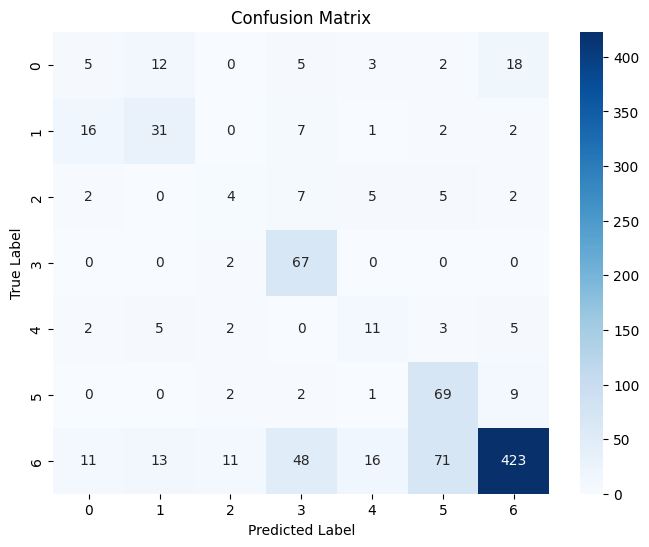

In [ ]:
# data_directory = '../../Datasets/RAF-DB_Structured_Aligned'
# data_directory = '../../Datasets/AffectNet_Structured_Aligned'
# data_directory = '../../Datasets/FER_Structured_Aligned'
# data_directory = '../../Datasets/JAFFE_Structured_Aligned'
data_directory = '../../Datasets/CK+_Structured_Aligned'
model_path = 'ModelsReadyForComparison/RAF-DB_Structured_Aligned.keras'

TestPAttLite(data_directory, model_path, dataset=['test'], ignored_labels=[7])